## Imports

In [0]:
import numpy as np                  #For NumPy arrays and mathematical functions
import pandas as pd                 #For operations using DataFrames
import matplotlib.pyplot as plt     #For plotting
import seaborn as sns               #For plotting
import time 
import os

## Mounting Google Drive on Colab

In [2]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


Creating File and Directory paths

In [0]:
dir_path = "gdrive/My Drive/Colab Notebooks/Datasets/NYC/"
file_name = "train.feather"

### Installing Feather locally for reading

In [0]:
!pip install -U feather-format

## Reading the dataset 

In [4]:
print("Reading Feather file...")
df = pd.read_feather(dir_path+file_name)
print("Reading completed")
%time

Reading Feather file...


/usr/local/lib/python3.6/dist-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Reading completed
CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 14.5 µs


### Now let's examine the properties of dataset


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [6]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134503e+01,-7.250972e+01,3.991985e+01,-7.251106e+01,3.992067e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


As we can see from the above description, our dataset contains a lot of anomalies and outliers. If a model is built without cleaning, it will be far from accurate. To build a good model, we will have to clean the data and add additional features

## Data Cleaning and Exploration

#### 1. Perform Initial Operations

Check shape of data

In [0]:
df.shape

(55423856, 7)

Check rows having NaN values

In [5]:
df.isnull().sum().sort_values(ascending=False)

dropoff_latitude     376
dropoff_longitude    376
passenger_count        0
pickup_latitude        0
pickup_longitude       0
pickup_datetime        0
fare_amount            0
dtype: int64

Dropping rows having NaN values
As only the first two columns contain NaN values, we choose a subset of column to check for dropping the rows and proceed with this to improve performance

In [0]:
df = df.dropna(axis='index', how='any', subset=['dropoff_latitude', 'dropoff_longitude'])

Now, after the rows are dropped, the shape will change

In [9]:
df.shape

(55423480, 7)

After having dropped the null rows, let us focus on making data good
The data contains a lot of issues - 
1. Fare Amount is negative
2. Latitude and Longitude 
3. Passenger Count


#### Step 1: Deleting rows having negative fare amount and fare above 95 dollars. 

The first task towards cleaning data would be removing rows having negative fare amount.

In [0]:
#Removing rows with negative fare
df = df[df.fare_amount > 0]

In [0]:
df.shape

(55419646, 7)

Let's plot a histogram checking for the distribution of fare_amount

Text(0.5,1,'Histogram')

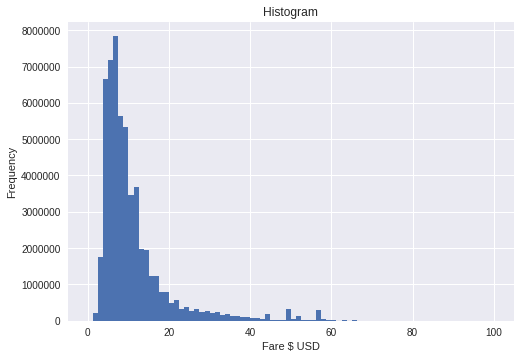

In [0]:
df[df.fare_amount<100].fare_amount.hist(bins=80)
plt.xlabel('Fare $ USD')
plt.ylabel('Frequency')
plt.title('Histogram')

This is a unimodal distribution. But even then, there exist fare amount greater than 150 dollars or so.
A simple observation at the distribution reveals that the maximum fare amount lies between 5 to 15 dollars. In order to trim the outliers, let us check the quantiles.

In [0]:
low =  0
high = .99953       #3.5-standard deviation, that means covering 99.953% observations
quantiles_df = df.quantile([low, high])
print(quantiles_df)

         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0.00000     0.010000      -3442.059570     -3492.263672       -3442.024658   
0.99953    95.330002         40.701997        41.012809          40.687964   

         dropoff_latitude  passenger_count  
0.00000      -3547.886719              0.0  
0.99953         40.989659              6.0  


As we can see, for 3.5 sigma, fare_amount -> 95 dollars. This means that the 99.953% of the observations lie below 95 dollars. **So it is safe to remove the outliers, that is, 0.047% observations.**


In [8]:
#Removing rows having having fare amount less than 3.5 sigma
df = df[df.fare_amount <= 95]
df.shape

(55393378, 7)

In [0]:
df.fare_amount.describe()

count    5.539338e+07
mean     1.128455e+01
std      9.371513e+00
min      1.000000e-02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.500000e+01
Name: fare_amount, dtype: float64

Even now, we can see that the minimum fare is $0.01.

But looking online for the taxi fares during the years 2009-2015, we understand that the minimum fare was $ 2. 
So we should only keep those rows for which the fare was above 2 dollars

In [9]:
#Removing rows with fare amount less than USD 2.
df = df[df.fare_amount >= 2]
df.shape

(55392531, 7)

In [0]:
low =  0
high = .9973         #3-standard deviation
quantiles_df = df.quantile([low, high])
print(quantiles_df)

        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0.0000         0.01       -3442.05957     -3492.263672       -3442.024658   
0.9973        60.00           0.00000        40.828285           0.000000   

        dropoff_latitude  passenger_count  
0.0000      -3547.886719              0.0  
0.9973         40.866947              6.0  


#### Step 2: Delete passengers more than 6.

We saw in the quantile plot above that 3 sigma as well as 3.5 sigma for passenger_count is 6.0, so let's drop rows having passenger_count > 6

In [10]:
#Dropping rows
df = df[df.passenger_count <= 6]
df.shape

(55392419, 7)

Also, removing rows with 0 passengers as a taxi cannot operate with 0 passengers

In [0]:
#Dropping rows
df = df[df.passenger_count > 0]

In [12]:
df.shape

(55197444, 7)

#### Step 3: Cleaning based on Coordinates

Now we try to understand latitudes and longitudes and remove outliers in these fields.

From basic Geography, we know that **Latitude** lies between -90 to +90.
And **Longitude** lies between -180 to +180.

But in our observation, we have a longitude of **-3446**, which clearly means that we need to remove outliers like these.

Leaving everything aside, I found out the bounding box coordinates for NYC as the cabs were in NYC. Reducing our observations to these bounding box coordinates would ensure that we have eliminated all outliers.

The coordinates for New York City are: 
-74.259087, 40.477398, -73.70018, 40.91618


In [15]:
df = df[(df.pickup_longitude >=  -74.259087) & (df.dropoff_longitude <= -73.70018)
          & (df.dropoff_longitude >= -74.259087) & (df.pickup_longitude <= -73.70018)
          & (df.pickup_latitude >= 40.477398) & (df.dropoff_latitude <= 40.91618)
          & (df.dropoff_latitude >= 40.477398) & (df.pickup_latitude <= 40.91618)]
df.shape

(53979707, 7)

In [0]:
df.describe()

Now we have sufficiently cleaned the data and it is free from outliers and looks uniform!

## Creating a new feature for Time of Day

In [0]:
df['time_of_day'] = df['pickup_datetime'].apply(lambda x:x.hour)
#df.head()

## Creating a new feature for Month of Year


In [0]:
df['month_of_year'] = df['pickup_datetime'].apply(lambda x:x.month)
#df.head()

## Creating a new feature for Year

In [0]:
df['year'] = df['pickup_datetime'].apply(lambda x:x.year)
#df.head()

## Creating a new feature for Day of Week

In [0]:
df['day_of_week'] = pd.to_datetime(df['pickup_datetime']).dt.weekday.astype(np.int64)

In [0]:
df.head()

In [26]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_of_day,month_of_year,year,day_of_week
count,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07,5.397971e+07
mean,1.126501e+01,-7.397079e+01,4.075009e+01,-7.397059e+01,4.075017e+01,1.691365e+00,1.351012e+01,6.269418e+00,2.011739e+03,3.041228e+00
std,9.294146e+00,3.441382e-02,2.688210e-02,3.377897e-02,3.071281e-02,1.307223e+00,6.516493e+00,3.436574e+00,1.865315e+00,1.949146e+00
min,2.000000e+00,-7.425903e+01,4.047759e+01,-7.425906e+01,4.047765e+01,1.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,6.000000e+00,-7.399229e+01,4.073658e+01,-7.399158e+01,4.073559e+01,1.000000e+00,9.000000e+00,3.000000e+00,2.010000e+03,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398061e+01,4.075385e+01,1.000000e+00,1.400000e+01,6.000000e+00,2.012000e+03,3.000000e+00
75%,1.250000e+01,-7.396835e+01,4.076752e+01,-7.396541e+01,4.076837e+01,2.000000e+00,1.900000e+01,9.000000e+00,2.013000e+03,5.000000e+00
max,9.500000e+01,-7.370018e+01,4.091616e+01,-7.370018e+01,4.091618e+01,6.000000e+00,2.300000e+01,1.200000e+01,2.015000e+03,6.000000e+00


## Calculating Euclidean Distance [Haversine Distance]

Referred this site: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula?rq=1

In [0]:
from math import sin, cos, asin, sqrt, radians

def euclidean_dist(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = (np.sin(dlat/2)**2 
         + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
    c = 2 * np.arcsin(np.sqrt(a)) 
    miles = 3959 * c
    return miles

In [0]:
df['euclidean_dist'] = euclidean_dist(df.loc[:,'pickup_longitude'].astype(float), 
                                      df.loc[:,'pickup_latitude'].astype(float),
                                      df.loc[:,'dropoff_longitude'].astype(float), 
                                      df.loc[:,'dropoff_latitude'].astype(float))

In [0]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_of_day,month_of_year,year,euclidean_dist
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,17,6,2009,0.640513
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,16,1,2010,5.250911
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,0,8,2011,0.863531
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1,4,4,2012,1.739456
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1,7,3,2010,1.242248


In [0]:
df.describe()

### Data Cleaning after adding new features

After calculating Euclidean distance, there is an important parameter to work with. We now will **clean** the rows that have distance travelled less than 0.3 miles as most of the people do not use cabs for distances as short as this! There are almost 2 million such entries and they can spoil the model

In [22]:
len(df[df.euclidean_dist <= 0.3 ])

2093705

In [0]:
#Removing rows having distance less than 0.3 miles
df = df[df.euclidean_dist >= 0.3]

In [24]:
df.shape

(51886002, 12)

# Now let's export this cleaned file!

In [0]:
#Creating a feather file
import feather
feather.write_dataframe(df,'gdrive/My Drive/Colab Notebooks/Datasets/NYC/train_cleaned.feather')

## Creating a correlation DataFrame

In [0]:
df_correlation = df.filter(['fare_amount', 'time_of_day', 'euclidean_dist'], axis=1)

# Calculating Pearson Correlation Coefficient

In [27]:
df_correlation.corr(method='pearson')

,fare_amount,time_of_day,euclidean_dist
fare_amount,1.000000,-0.018592,0.904927
time_of_day,-0.018592,1.000000,-0.032418
euclidean_dist,0.904927,-0.032418,1.000000


In [0]:
sns.pairplot(df_correlation)

## Converting to CSV File

In [0]:
#df.to_csv(path="gdrive/My Drive/Colab Notebooks/Datasets/NYC/train_cleaned.csv")
df.to_csv("gdrive/My Drive/Colab Notebooks/Datasets/NYC/train_cleaned.csv",encoding='utf-8',index=False)

## Converting to Feather File

In [0]:
df_1 = df
df_1.reset_index()
#df_1.head()
#df_1.to_feather("gdrive/My Drive/Colab Notebooks/Datasets/NYC/train_cleaned.feather")
df_1.to_feather("gdrive/My Drive/Colab Notebooks/Datasets/NYC/train_cleaned.feather")

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_of_day,month_of_year,year,euclidean_dist
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,17,6,2009,0.640513
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,16,1,2010,5.250911
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,0,8,2011,0.863531
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1,4,4,2012,1.739456
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1,7,3,2010,1.242248


## Plotting the relationship betweeen variables

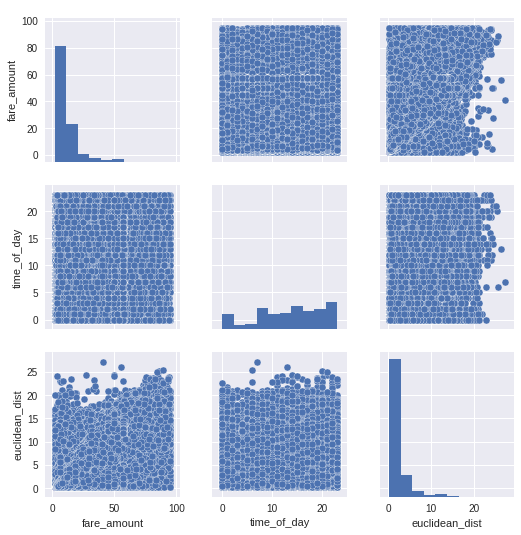

In [0]:
sns.pairplot(df_correlation[:10000000])

The plots do not show a very linear kind of relationship, but fare_amount and euclidean_dist are highly correlated

In [0]:
df_reduced = df.sample(frac=0.2, random_state=42)


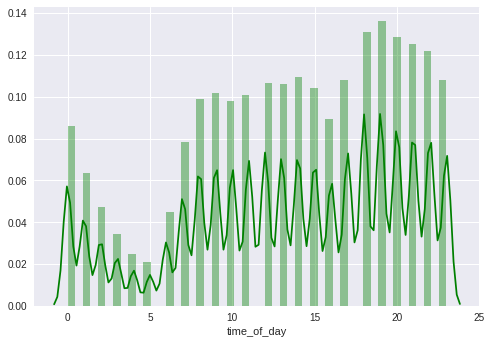

In [31]:
#Creating a distribution plot to check the frequency of cab bookings according to the hour of day
sns.distplot(df_reduced['time_of_day'], color="green")

From this graph, it is evident that the highest number of cab bookings are done in between 6PM to 9PM, and this coincides with the closing time of offices in NYC. Also the bookings done at late night [12AM to 5AM] could be people travelling to/from airports! 

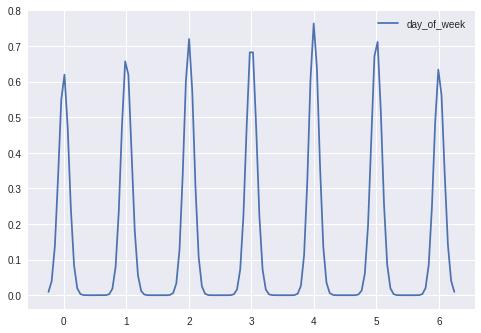

In [30]:
sns.kdeplot(df_reduced['day_of_week'])

This plot shows that the distribution is more or less similar for every day
I have drawn a Kernel Density Estimation plot here!

In [0]:
sns.jointplot("euclidean_dist", "fare_amount", data=df_reduced, kind='hex')

In [0]:
df_reduced = df_reduced[:1000000]

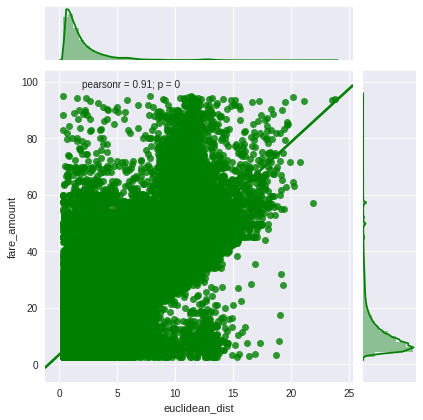

In [35]:
sns.jointplot("euclidean_dist", "fare_amount", data=df_reduced,color='green', kind='reg')

This plot also reveals an interesting insight into the data! The correlation is quite high and can be seen from the line!

# Building Linear Regression Model based on the above features


In [0]:
import numpy as np                  #For NumPy arrays and mathematical functions
import pandas as pd                 #For operations using DataFrames
import matplotlib.pyplot as plt     #For plotting
import seaborn as sns               #For plotting
import time 
import os

In [2]:
dir_path = "gdrive/My Drive/Colab Notebooks/Datasets/NYC/"
file_name = "train_cleaned.feather"
df_lin = pd.read_feather(dir_path+file_name, nthreads=2)
%time

/usr/local/lib/python3.6/dist-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 9.78 µs


In [0]:
print(df_lin.shape)
df_lin.head()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
#from IPython.html import widgets
#from IPython.html.widgets import interact
#from IPython.display import display

In [0]:
df_subset = df_lin.sample(frac=0.5, random_state=42)

In [14]:
df_subset.shape

(25943001, 12)

In [0]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'euclidean_dist','time_of_day', 'day_of_week']

X1 = df_subset[features].values

Y = df_subset[['fare_amount']].values

X1_train, X1_test, y_train, y_test = train_test_split(X1, Y, test_size=0.3, random_state=0)

In [16]:
slr = LinearRegression()
slr.fit(X1_train, y_train)
y_train_pred = slr.predict(X1_train)
y_test_pred = slr.predict(X1_test)
slr.coef_

array([[ 1.26752508e+01,  8.25524376e+00, -5.74357322e+00,
        -1.50032256e+01,  3.70326356e+00,  1.07440275e-02,
        -4.96219671e-02]])

When frac=0.5 <br>
array([[ 1.26752508e+01,  8.25524376e+00, -5.74357322e+00,
        -1.50032256e+01,  3.70326356e+00,  1.07440275e-02,
        -4.96219671e-02]])

For frac=0.2<br>array([[ 1.26912264e+01,  8.28425098e+00, -5.60640618e+00,
        -1.50239738e+01,  3.70220438e+00,  1.05555875e-02,
        -5.09145992e-02]])

In [17]:
from math import sqrt
import numpy as np
print ('Simple Linear Regression on Euclidean Distance Results:')
print ('Root Mean Squared Error Train: %.5f' % np.sqrt(mean_squared_error(y_train,y_train_pred)))
print ('Root Mean Squared Error Test: %.5f' % np.sqrt(mean_squared_error(y_test,y_test_pred)))

Simple Linear Regression on Euclidean Distance Results:
Root Mean Squared Error Train: 3.87634
Root Mean Squared Error Test: 3.87814


Simple Linear Regression over 50%  of dataset Results:
Root Mean Squared Error Train: 3.87634
Root Mean Squared Error Test: 3.87814

Simple Linear Regression frac=0.2 Results:
Root Mean Squared Error Train: 3.86948
Root Mean Squared Error Test: 3.87446

# Checking results with the Test File

In [0]:
dir_path = "gdrive/My Drive/Colab Notebooks/Datasets/NYC/"
file_name = "test.csv"

In [0]:
df_test = pd.read_csv(dir_path+file_name)

In [0]:
df_test.head()

In [0]:
from math import sin, cos, asin, sqrt, radians

def euclidean_dist(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = (np.sin(dlat/2)**2 
         + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
    c = 2 * np.arcsin(np.sqrt(a)) 
    miles = 3959 * c
    return miles

In [0]:
df_test['euclidean_dist'] = euclidean_dist(df_test.loc[:,'pickup_longitude'].astype(float), 
                                      df_test.loc[:,'pickup_latitude'].astype(float),
                                      df_test.loc[:,'dropoff_longitude'].astype(float), 
                                      df_test.loc[:,'dropoff_latitude'].astype(float))

In [0]:
df_test['time_of_day'] = pd.to_datetime(df_test['pickup_datetime']).dt.hour
df_test['year'] = pd.to_datetime(df_test['pickup_datetime']).dt.year
df_test['day_of_week'] = pd.to_datetime(df_test['pickup_datetime']).dt.weekday.astype(np.int64)
df_test['month_of_year'] = pd.to_datetime(df_test['pickup_datetime']).dt.month

In [10]:
df_test.shape

(9914, 12)

In [11]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'euclidean_dist','time_of_day', 'day_of_week']

X1_train = df_subset[features].values
y_train  = df_subset[['fare_amount']].values
X1_test  = df_test[features].values

slr = LinearRegression()
model = slr.fit(X1_train, y_train)
pred = model.predict(X1_test)
slr.coef_

print(pred[:10])

[[ 9.23534548]
 [ 9.10376691]
 [ 4.82819657]
 [ 8.15740108]
 [16.50943335]
 [11.40557623]
 [ 5.77304848]
 [54.6477168 ]
 [11.84817396]
 [ 6.09650996]]


In [12]:
df_submit = df_test[['key']]
df_submit['fare_amount'] = pred
df_submit.to_csv(dir_path+"linear_reg_2.csv", index=False)
print("Done!")

Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df_submit.shape

(9914, 2)

## Kaggle RMSE for Linear Regression: 5.814, 5.912, 5.813

---



# Random Forest

In [0]:
import numpy as np                  #For NumPy arrays and mathematical functions
import pandas as pd                 #For operations using DataFrames
import matplotlib.pyplot as plt     #For plotting
import seaborn as sns               #For plotting
import time 
import os

In [0]:
from google.colab import drive
drive.mount('gdrive')

In [0]:
dir_path = "gdrive/My Drive/Colab Notebooks/Datasets/NYC/"
file_name = "train_cleaned.feather"

In [0]:
!pip install -U feather-format

In [0]:
df = pd.read_feather(dir_path+file_name, nthreads=2)

/usr/local/lib/python3.6/dist-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [0]:
# Loading 20% of the dataset
df_subset = df.sample(frac=0.1, random_state=42)
df_subset.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_of_day,month_of_year,year,euclidean_dist,day_of_week
44976798,12.5,2011-02-15 11:29:00+00:00,-73.998558,40.724583,-73.995834,40.767811,1,11,2,2011,2.990362,1
45538027,4.9,2009-09-26 04:04:00+00:00,-73.988586,40.733788,-73.976578,40.727203,1,4,9,2009,0.776115,5
47711137,10.1,2012-07-28 10:09:00+00:00,-73.992920,40.755295,-73.977371,40.784374,4,10,7,2012,2.167814,5
19321254,6.5,2012-05-09 22:24:00+00:00,-73.986252,40.726101,-73.981277,40.744148,6,22,5,2012,1.273934,2
49976425,12.5,2012-02-08 20:05:00+00:00,-73.994736,40.726070,-73.966980,40.758049,1,20,2,2012,2.644608,2


In [0]:
df_subset.shape

(518860, 12)

In [0]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'euclidean_dist', 'year', 'day_of_week', 'time_of_day']
X = df_subset[features].values
y = df_subset['fare_amount'].values

In [0]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [0]:
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error
print ('Random Forest Results:')
print ('Root Mean Squared Error Train: %.5f' % np.sqrt(mean_squared_error(y_train,y_train_pred)))
print ('Root Mean Squared Error Test: %.5f' % np.sqrt(mean_squared_error(y_test,y_test_pred)))

# Checking with Test File

In [0]:
dir_path = "gdrive/My Drive/Colab Notebooks/Datasets/NYC/"
file_name = "test.csv"

In [0]:
df_test = pd.read_csv(dir_path+file_name)

In [0]:
from math import sin, cos, asin, sqrt, radians

def euclidean_dist(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = (np.sin(dlat/2)**2 
         + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
    c = 2 * np.arcsin(np.sqrt(a)) 
    miles = 3959 * c
    return miles

In [0]:
df_test['euclidean_dist'] = euclidean_dist(df_test.loc[:,'pickup_longitude'].astype(float), 
                                      df_test.loc[:,'pickup_latitude'].astype(float),
                                      df_test.loc[:,'dropoff_longitude'].astype(float), 
                                      df_test.loc[:,'dropoff_latitude'].astype(float))

In [0]:
df_test['time_of_day'] = pd.to_datetime(df_test['pickup_datetime']).dt.hour
df_test['year'] = pd.to_datetime(df_test['pickup_datetime']).dt.year
df_test['day_of_week'] = pd.to_datetime(df_test['pickup_datetime']).dt.weekday.astype(np.int64)
df_test['month_of_year'] = pd.to_datetime(df_test['pickup_datetime']).dt.month

In [0]:
df_test.head()

In [0]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'passenger_count', 'euclidean_dist', 'year', 'day_of_week', 'time_of_day']
X_train = df_subset[features].values
y_train = df_subset['fare_amount'].values
X_test = df_test[features].values

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(y_test_pred[:10])

In [0]:
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error
print ('Random Forest Results:')
print ('Root Mean Squared Error Train: %.5f' % np.sqrt(mean_squared_error(y_train,y_train_pred)))
print ('Root Mean Squared Error Test: %.5f' % np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [0]:
df_submit = df_test[['key']]
df_submit['fare_amount'] = y_test_pred
df_submit.to_csv(dir_path+"rf_regressor_n100.csv", index=False)
print("Done!")

Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Random Forest RMSE over Kaggle: 
## 1. No. of rows = 1/100 * Cleaned Dataset [Around 520,000 rows] and n_estimators = 50 -> *`RMSE: 3.45618`*
## 2. No. of rows = 1/10 * Cleaned Dataset [Around 5.2 million rows] and n_estimators = 100 -> *`RMSE: 3.43151`*

## **END OF FILE**

---

